In [35]:
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
from pytorchvideo.models.hub import x3d_s
from collections import Counter
import numpy as np
from tqdm import tqdm

In [26]:
def load_model(checkpoint, device):
    checkpoint = torch.load(checkpoint, map_location=device)
    label_to_idx = checkpoint['label_to_idx']
    idx_to_label = checkpoint['idx_to_label']
    num_classes = len(label_to_idx)

    model = x3d_s(pretrained=False)
    in_features = model.blocks[-1].proj.in_features
    model.blocks[-1].proj = nn.Linear(in_features, num_classes)

    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()    

    return model, label_to_idx, idx_to_label

In [27]:
model, label_to_idx, idx_to_label = load_model("./best_model.pth", "cuda")

In [21]:
from Dataset import SoccerActionDataset
allowed_classes = ['HEADER', 'HIGH PASS', 'OUT']
test_ds = SoccerActionDataset("./data/720p/test", "Labels-ball.json", num_frames=16, allowed_classes=allowed_classes)

In [23]:
test_ds.label_to_idx = label_to_idx
test_ds.idx_to_label = idx_to_label

In [28]:
test_loader = DataLoader(test_ds, shuffle=False, batch_size=8, num_workers=4, pin_memory=True)

In [38]:
def evaluate_model(model, test_loader, device, idx_to_label, label_to_index):
    """
    Evaluate model on test set
    
    Args:
        model: Trained model
        test_loader: DataLoader for test data
        device: Device to run on
        idx_to_label: Index to label mapping
    
    Returns:
        accuracy: Overall accuracy
        per_class_acc: Per-class accuracy dictionary
    """
    model.eval()
    
    correct = 0
    total = 0
    
    # Per-class statistics
    class_correct = {}
    class_total = {}
    
    # Confusion matrix data
    all_predictions = []
    all_labels = []
    
    print("\nEvaluating on test set...")
    
    with torch.no_grad():
        for frames, labels in tqdm(test_loader):
            frames, labels = frames.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(frames)
            _, predicted = torch.max(outputs, 1)
            
            # Overall accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store for confusion matrix
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Per-class accuracy
            for label, pred in zip(labels.cpu().numpy(), predicted.cpu().numpy()):
                if label not in class_total:
                    class_total[label] = 0
                    class_correct[label] = 0
                class_total[label] += 1
                if label == pred:
                    class_correct[label] += 1
    
    # Calculate overall accuracy
    accuracy = 100. * correct / total
    
    # Calculate per-class accuracy
    per_class_acc = {}
    for class_idx in sorted(class_total.keys()):
        class_name = idx_to_label[class_idx]
        acc = 100. * class_correct[class_idx] / class_total[class_idx]
        per_class_acc[class_name] = acc
    
    # Print results
    print(f"\n{'='*70}")
    print(f"Test Results")
    print(f"{'='*70}")
    print(f"Overall Accuracy: {accuracy:.2f}% ({correct}/{total})")
    print(f"\nPer-class Accuracy:")
    for class_name, acc in per_class_acc.items():
        # count = class_correct[idx_to_label.index(class_name)]
        # total_count = class_total[idx_to_label.index(class_name)]
        count = class_correct[label_to_index[class_name]]
        total_count = class_total[label_to_index[class_name]]        
        print(f"  {class_name:25s}: {acc:5.1f}% ({count:3d}/{total_count:3d})")
    print(f"{'='*70}\n")
    
    return accuracy, per_class_acc, all_predictions, all_labels


# Run evaluation
accuracy, per_class_acc, predictions, labels = evaluate_model(
    model, test_loader, device, idx_to_label, label_to_idx
)


Evaluating on test set...


100%|██████████| 380/380 [04:15<00:00,  1.49it/s]


Test Results
Overall Accuracy: 80.26% (2436/3035)

Per-class Accuracy:
  HEADER                   :  72.5% (792/1092)
  HIGH PASS                :  92.3% (992/1075)
  OUT                      :  75.1% (652/868)



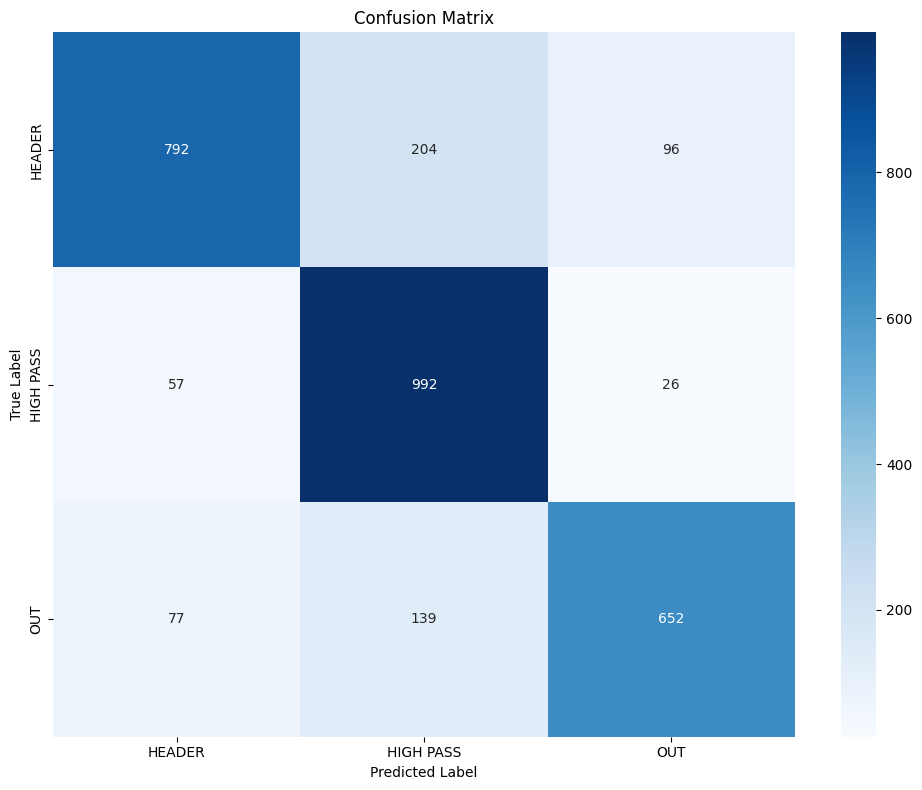

Confusion matrix saved as 'confusion_matrix.png'

Classification Report:
              precision    recall  f1-score   support

      HEADER      0.855     0.725     0.785      1092
   HIGH PASS      0.743     0.923     0.823      1075
         OUT      0.842     0.751     0.794       868

    accuracy                          0.803      3035
   macro avg      0.814     0.800     0.801      3035
weighted avg      0.812     0.803     0.801      3035



In [40]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(all_labels, all_predictions, idx_to_label):
    """Plot confusion matrix"""
    # Get class names in order
    class_names = [idx_to_label[i] for i in sorted(idx_to_label.keys())]
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Confusion matrix saved as 'confusion_matrix.png'")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(
        all_labels, 
        all_predictions, 
        target_names=class_names,
        digits=3
    ))

# Plot confusion matrix
plot_confusion_matrix(labels, predictions, idx_to_label)